In [265]:
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from astropy.io import fits

In [266]:
# change some default plotting parameters
import matplotlib as mpl
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['image.cmap'] = 'Greys_r'

# run the %matplotlib magic command to enable inline plotting
# in the current Notebook
%matplotlib inline

In [267]:
zeroes=os.listdir("20181018/Zeroes/")
mars=os.listdir("20181018/Mars/")
comps=os.listdir("20181018/comps/")
darks=os.listdir("20181018/Darks/")
BobRoss=os.listdir("BobRoss/")
marsNotGarbage=os.listdir("20181018/marsNotGarbage/")
bkgS=os.listdir("bkg/")
print(bkg)

[[ 14.78127918   7.85499533  10.46723856 ...  13.72965686  13.27760271
    4.86165966]
 [ 14.80056073   7.89599724  10.49975845 ...  13.68242754  13.26523464
    4.87189441]
 [ 14.81984228   7.93699915  10.53227835 ...  13.63519821  13.25286658
    4.88212916]
 ...
 [ 24.55702665  28.64296269  26.95482381 ... -10.21561168   7.00699468
   10.05067592]
 [ 24.5763082   28.6839646   26.98734371 ... -10.26284101   6.99462662
   10.06091067]
 [ 24.59558976  28.72496651  27.0198636  ... -10.31007033   6.98225856
   10.07114541]]


In [268]:
print(zeroes,mars,comps,darks,marsNotGarbage)

['z004.FIT', 'z005.FIT', 'z007.FIT', 'z006.FIT', 'z002.FIT', 'z003.FIT', 'z001.FIT', 'z008.FIT', 'z009.FIT'] ['Mars7Tilt2.FIT', 'Mars10Tilt3.FIT', 'Mars3.FIT', 'Mars2.FIT', 'Mars1.FIT', 'Mars5.FIT', 'Mars4.FIT', 'Mars6.FIT', 'Mars9Tilt3.FIT', 'Mars8Tilt2.FIT'] ['Comp2Ar.FIT', 'Comp1Ar.FIT'] ['d001.FIT', 'd002.FIT', 'd003.FIT'] ['Mars10Tilt3.FIT', 'Mars2.FIT', 'Mars1.FIT', 'Mars4.FIT', 'Mars9Tilt3.FIT']


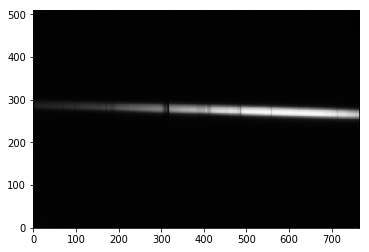

In [269]:
test=fits.open('20181018/Mars/Mars9Tilt3.FIT')[0].data.astype(np.float) 
plt.imshow(test)

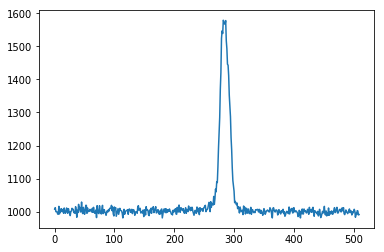

In [270]:
plt.figure()  # Start a new plot -- by default matplotlib overplots.
plt.plot(test[:,100])

## Bias correction

In [271]:
nrow,ncol=np.shape(fits.open('20181018/Zeroes/z001.FIT')[0].data.astype(np.float))

alldata=np.ones((len(zeroes),nrow,ncol))

for i in range (0,len(zeroes)):
    sci_fn = '20181018/Zeroes/'+zeroes[i]
    sci_hdulist = fits.open(sci_fn)
    alldata[i,:,:] = sci_hdulist[0].data.astype(np.float)

masterbias= np.median(alldata,axis=0)

In [272]:
masterbias

array([[994., 985., 990., ..., 965., 962., 966.],
       [987., 992., 991., ..., 963., 969., 968.],
       [989., 988., 988., ..., 970., 970., 970.],
       ...,
       [986., 989., 988., ..., 964., 971., 965.],
       [984., 988., 985., ..., 964., 967., 974.],
       [993., 993., 986., ..., 971., 968., 973.]])

In [273]:
def unbias(file,directory='Mars/'):
    sci_fn = "20181018/"+directory+file
    out= "CNN/"+file
    sci_hdulist = fits.open(sci_fn)
    biased = sci_hdulist[0].data.astype(np.float)
    biascor= biased-masterbias
    hdu = fits.PrimaryHDU(biascor)
    hdu.writeto(out, overwrite=True)

In [274]:
##'Pythonic' method to unbias all mars spectra
[unbias(file) for file in mars]
[unbias(file,'Darks/') for file in darks]
[unbias(file, 'comps/') for file in comps]

[None, None]

## Dark Correction

In [275]:
nrow,ncol=np.shape(fits.open('CNN/d001.FIT')[0].data.astype(np.float))
alldata=np.ones((len(darks),nrow,ncol))

for i in range (0,len(darks)):
    sci_fn = 'CNN/'+darks[i]
    sci_hdulist = fits.open(sci_fn)
    alldata[i,:,:] = sci_hdulist[0].data.astype(np.float)

masterdark= np.median(alldata,axis=0)

In [276]:
def lightenUp(file,directory='CNN/'):
    sci_fn = directory+file
    out= "BobRoss/"+file
    sci_hdulist = fits.open(sci_fn)
    darkened = sci_hdulist[0].data.astype(np.float)
    undarkened= darkened-masterdark
    hdu = fits.PrimaryHDU(undarkened)
    hdu.writeto(out, overwrite=True)

In [277]:
##'Pythonic' method to unbias all mars spectra
[lightenUp(file) for file in mars]
[lightenUp(file) for file in comps]

[None, None]

## Sky Background

In [278]:
sci_fn="BobRoss/Mars1.FIT"
sci_hdulist = fits.open(sci_fn)
spec = sci_hdulist[0].data.astype(np.float)

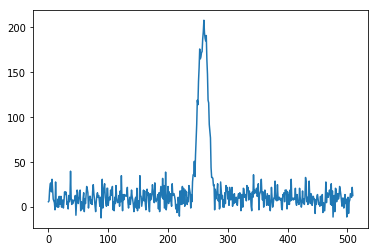

In [279]:
plt.figure()  # Start a new plot -- by default matplotlib overplots.
plt.plot(spec[:,382])

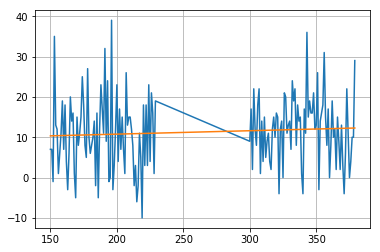

In [280]:
y=np.append(np.arange(150,230),np.arange(300,380))
x=spec[y,382]
plt.figure()
plt.plot(y, x)
pfit = np.polyfit(y, x, 1)  # Fit a 1st order polynomial to (x, y) data
xfit = np.polyval(pfit, y)  # Evaluate the polynomial at x
plt.plot(y, xfit)
plt.grid()

In [281]:
print(np.mean(x))
print(np.mean(spec))

11.3125
23.463360246059207


In [282]:
ycols = np.arange(spec.shape[0])            # Array from 0 .. N_rows-1
bkg = np.zeros_like(spec)                   # Empty image for background fits
for row in np.arange(spec.shape[1]):        # For each row ...
    pfit = np.polyfit(y, spec[y,row], 1)    # Fit poly over bkg col for row
    bkg[:,row] = np.polyval(pfit, ycols)    # Eval poly at ALL row positions

In [283]:
spec.shape[1]

765

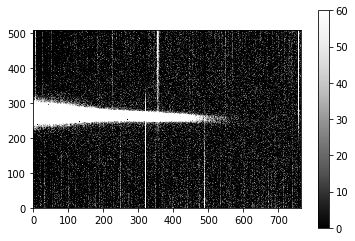

In [284]:
spec_bkg = spec - bkg
plt.clf()
plt.imshow(spec_bkg, origin = 'lower', vmin=0, vmax=60)
plt.colorbar()

In [285]:
y=np.append(np.arange(150,230),np.arange(300,380))
def unbg(file,directory='Mars/'):
    sci_fn = 'BobRoss/'+file
    out= "bkg/bkg_"+file
    flatspec = fits.open(sci_fn)[0].data.astype(np.float)
    x = flatspec[y, 382]  
    pfit = np.polyfit(y,x, 1)  
    ycols = np.arange(flatspec.shape[0])            # Array from 0 .. N_rows-1
    bkg = np.zeros_like(flatspec)                   # Empty image for background fits
    for row in np.arange(flatspec.shape[1]):        # For each row ...
       pfit = np.polyfit(y, flatspec[y,row], 1)     # Fit poly over bkg col for row
       bkg[:,row] = np.polyval(pfit, ycols)         # Eval poly at ALL row positions
    bkgsub=flatspec-bkg
    hdu = fits.PrimaryHDU(bkgsub)
    hdu.writeto(out, overwrite=True)

In [286]:
[unbg(file) for file in os.listdir('BobRoss')]

[None, None, None, None, None, None, None, None, None, None, None, None]

In [287]:
flatspec.shape[1]

765

In [288]:
BobRoss

['Comp2Ar.FIT',
 'Mars7Tilt2.FIT',
 'Comp1Ar.FIT',
 'Mars10Tilt3.FIT',
 'Mars3.FIT',
 'Mars2.FIT',
 'Mars1.FIT',
 'Mars5.FIT',
 'Mars4.FIT',
 'Mars6.FIT',
 'Mars9Tilt3.FIT',
 'Mars8Tilt2.FIT']

### Spectrum extraction
Now we're ready to extract the 1D spectra from the background-subtracted frame, and then to extract the calibration lamp spectra the same way. Let's first inspect a plot of one of these background-subtracted frames across line 512:

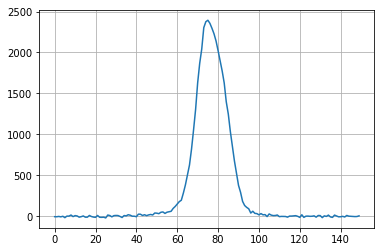

In [289]:
sci_fn="bkg/bkg_Mars9Tilt3.FIT"
sci_hdulist = fits.open(sci_fn)
spec = sci_hdulist[0].data.astype(np.float)
plt.figure()  

plt.plot(spec[200:350,382])  #This is the last frame from the loop above
plt.grid()

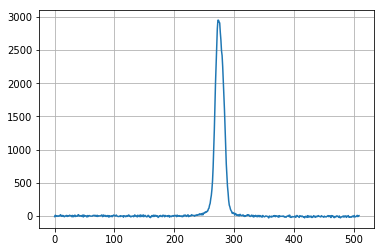

In [290]:
plt.figure()
plt.plot(spec[:,420])
plt.grid()

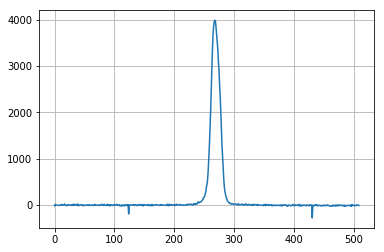

In [291]:
plt.figure()
plt.plot(spec[:, 633])
plt.grid()

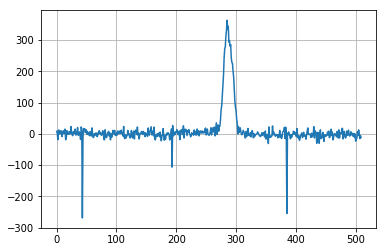

In [292]:
plt.figure()
plt.plot(spec[:,1])
plt.grid()

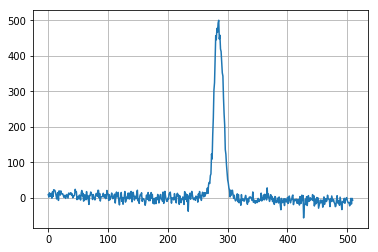

In [293]:
plt.figure()
plt.plot(spec[:,69])
plt.grid()

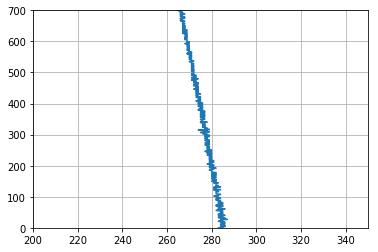

In [294]:
specrow=np.argmax(spec,axis=0)
y=np.arange(0, len(spec[275, :]))
plt.figure()
plt.xlim(200,350)
plt.ylim(0,700)
plt.plot(specrow,y)
plt.grid()

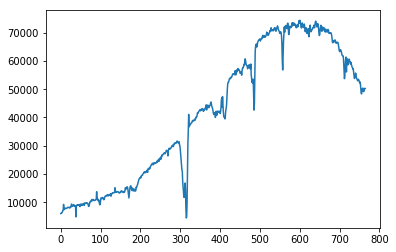

In [295]:
ext_spec = spec[250:350,:].sum(axis=0)
plt.figure()   
plt.plot(ext_spec) 

In [296]:
ext_spec=np.zeros((len(bkg),765))

for i in range (0,len(bkgS)):
    sci_fn = "bkg/"+bkgS[i]
    sci_hdulist = fits.open(sci_fn)
    bkgspec = sci_hdulist[0].data.astype(np.float)
    ext_spec[i,:] = bkgspec[250:350,:].sum(axis=0)

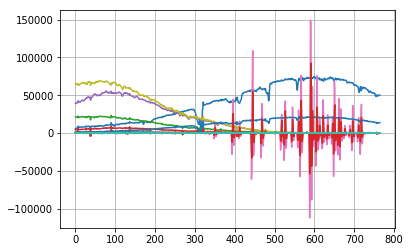

In [307]:
plt.figure()
[plt.plot(f) for f in ext_spec]
#plt.plot(ext_spec[13])
plt.grid()

We now have reduced, extracted spectra in arrays labeled ext_spec[0], ext_spec[1], etc.

### Dispersion solution
We are now ready to find the dispersion solution and apply it. To do this, we must use the calibration lamp spectrum and identify as many lines as we can. In most cases, you want to use calibration lamp spectra taken at the same telescope position as the object spectrum. This accounts for small wavelength shifts that can arise from flexture in the instrument as it as placed at different angles to point the telescope.

First, we'll extract the comparison spectra the same way we did the data spectra, and plot one of them.

In [298]:
ext_comp=[]
def makeComp(compa):
    comp_fn="BobRoss/"+compa
    comp_hdulist = fits.open(comp_fn)
    comp = comp_hdulist[0].data.astype(np.float)
    ext_comp.append(comp[250:350,:].sum(axis=0))

In [299]:
[makeComp(comp) for comp in comps]

[None, None]

In [300]:
ext_comp

[array([  4258.,   4422.,   4025.,   4073.,   4453.,   4234.,   4416.,
          4219.,   4529.,   4563.,   4361.,   4325.,   4200.,   4526.,
          4150.,   4217.,   4514.,   4610.,   4526.,   4648.,   4854.,
          4729.,   4971.,   4930.,   4896.,   4771.,   4323.,   4518.,
          4437.,   4050.,   4297.,   4558.,   4421.,   4577.,   4444.,
          4196.,   4406.,   4738.,   1214.,   5994.,   6148.,   5599.,
          4912.,   4707.,   4418.,   4429.,   4621.,   4574.,   3832.,
          4652.,   4527.,   4757.,   3552.,   4457.,   4134.,   4404.,
          4595.,   4731.,   4739.,   4450.,   4759.,   4574.,   4882.,
          5255.,   4914.,   4889.,   3314.,   5048.,   5475.,   5911.,
          5744.,   5348.,   5290.,   5421.,   5649.,   5038.,   4898.,
          4499.,   4718.,   4631.,   5045.,   4883.,   5130.,   5522.,
          5643.,   5485.,   5050.,   4366.,   5079.,   5031.,   4906.,
          4988.,   4668.,   4903.,   4647.,   4793.,   5064.,   5157.,
      

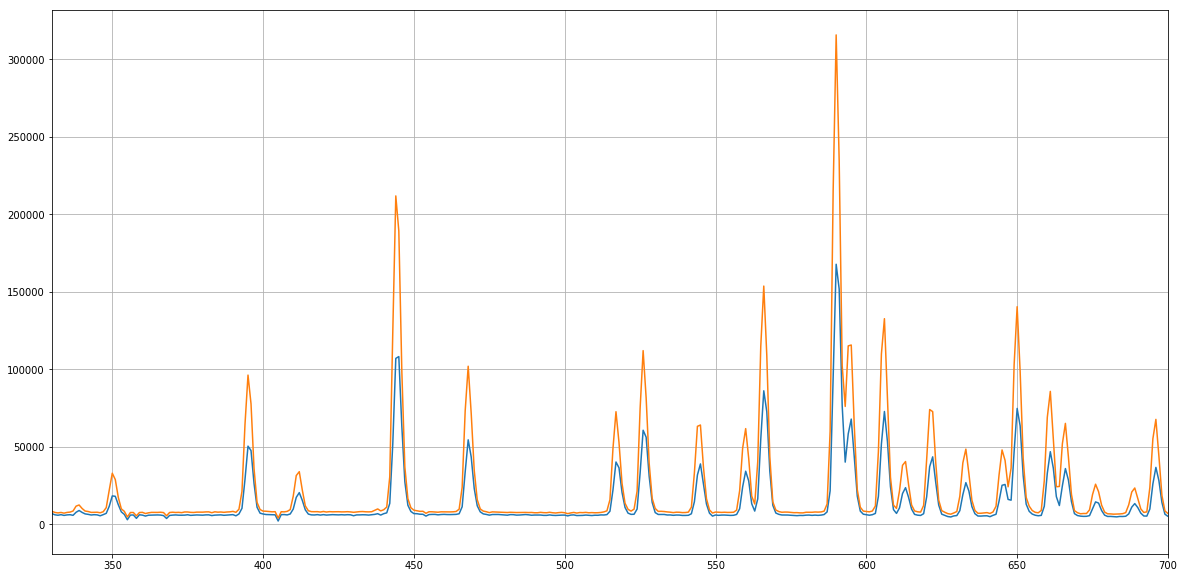

In [301]:
plt.figure(figsize=(20,10))  # Start a new plot -- by default matplotlib overplots.
[plt.plot(comp) for comp in ext_comp]
plt.xlim(330, 700) 
plt.grid()

Now, you need to identify several lines in the spectrum and associate them with rows on the CCD. You can do this by zooming in on the plot above- by uncommenting and adjusting the xlim command above. For example, the strong line at 4609.5673 A lies at pixel (row) 308.

It is ok to use half pixel values in cases where the line maximum spreads across 2 pixels.


**QUESTION** Complete the following tables:

| comp1.fits|         |
|------------|---------|
| wavelength | pixel   |
|------------|---------|      
|  750 |    590  |
|------------|---------|
|  746.5 |    566  |
|------------|---------|
|  761 | 606     |
|------------|---------|
|  4589.8978 |  650  |
|------------|---------|
|  4579.3495 |  430       |
|------------|---------|
|  4545.0519 |     585    |
|------------|---------|
|  4493.3337 |    810     |
|------------|---------|
|  4481.8107 |    880     |
|------------|---------|
|  4474.7594 |     905    |
|------------|---------|
|  4445.9012 |     1030 |
|------------|---------|

Change the spectrum plotted by changing ext_comp1 to ext_comp2 and again, use the xlim command to zoom in and find the pixel values for each line. The 4609.5673 line falls at pixel 308, as above. Other lines may be at the same pixel positions as in the above table, or at slightly different positions. 

| comp2.fits|         |
|------------|---------|
| wavelength | pixel   |
|------------|---------|      
|  4673.6609 |   589      |
|------------|---------|
|  4657.9012 |      566   |
|------------|---------|
|  4609.5673 | 308     |
|------------|---------|
|  4589.8978 |    395     |
|------------|---------|
|  4579.3495 |     420    |
|------------|---------|
|  4545.0519 |    585     |
|------------|---------|
|  4493.3337 |     808    |
|------------|---------|
|  4481.8107 |    882     |
|------------|---------|
|  4474.7594 |     905    |
|------------|---------|
|  4445.9012 |     1030    |
|------------|---------|
  
  

In [302]:
x1=[590,566,606]
x2=[589,566]
y1=[750,746.5,761]
y2=[750,746.5]

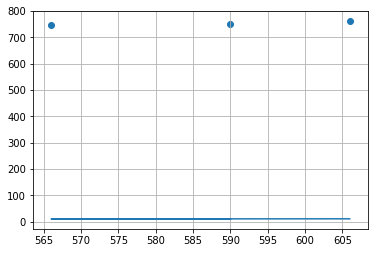

In [303]:
pfit1 = np.polyfit(x1, y1, 1)  # Fit a 1st order polynomial to (x1, y) data
yfit1 = np.polyval(pfit, x1)  # Evaluate the polynomial at x1
plt.plot(x1, yfit1)
plt.scatter(x1,y1)
plt.grid()

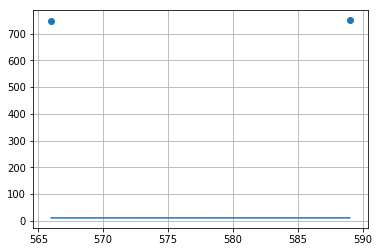

In [304]:
pfit2 = np.polyfit(x2, y2, 1)  # Fit a 1st order polynomial to (x1, y) data
yfit2 = np.polyval(pfit, x2)  # Evaluate the polynomial at x1
plt.plot(x2, yfit2)
plt.scatter(x2,y2)
plt.grid()

In [334]:
wavefit=[0]*510
for i in np.arange(len(wavefit)):
    #plt.figure()
    xrow=np.arange(0, 765)
    wavefit[i]=np.polyval(pfit1, xrow)
    #plt.plot(wavefit[i],ext_spec[0])
    #plt.grid()

In [336]:
print(wavefit[0])

[549.63815789 549.98355263 550.32894737 550.67434211 551.01973684
 551.36513158 551.71052632 552.05592105 552.40131579 552.74671053
 553.09210526 553.4375     553.78289474 554.12828947 554.47368421
 554.81907895 555.16447368 555.50986842 555.85526316 556.20065789
 556.54605263 556.89144737 557.23684211 557.58223684 557.92763158
 558.27302632 558.61842105 558.96381579 559.30921053 559.65460526
 560.         560.34539474 560.69078947 561.03618421 561.38157895
 561.72697368 562.07236842 562.41776316 562.76315789 563.10855263
 563.45394737 563.79934211 564.14473684 564.49013158 564.83552632
 565.18092105 565.52631579 565.87171053 566.21710526 566.5625
 566.90789474 567.25328947 567.59868421 567.94407895 568.28947368
 568.63486842 568.98026316 569.32565789 569.67105263 570.01644737
 570.36184211 570.70723684 571.05263158 571.39802632 571.74342105
 572.08881579 572.43421053 572.77960526 573.125      573.47039474
 573.81578947 574.16118421 574.50657895 574.85197368 575.19736842
 575.54276316 

In [316]:
print(xrow)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [317]:
ext_spec[0]

array([ 5957.76694373,  6132.63508809,  6096.09896277,  6413.03161409,
        6478.48714123,  7009.61040068,  7209.48945013,  9207.9614237 ,
        7355.16947286,  7404.67444587,  7561.46195652,  7915.45179739,
        7803.32043905,  7771.5816283 ,  7803.06468457,  7836.59160983,
        7977.45094487,  8188.05601733,  8115.56500426,  8104.6869139 ,
        8089.82931941,  8221.65139244,  7949.39286729,  7961.37993748,
        8163.80090224,  8479.99730037,  8376.01147343,  9322.91066354,
        8476.22822535,  8635.78449133,  8574.25404945,  8727.53786587,
        9144.94213555,  9064.4481742 ,  8657.78498863,  8530.16286587,
        8671.30296249,  8632.20570475,  4791.0738491 ,  8756.83226769,
        8882.97222222,  8833.13448423,  9125.08027849,  9000.62226485,
        9007.60155584,  8879.19892015,  9116.60386473,  8905.00486644,
        8427.54468599,  9281.89709434,  8935.34050867,  9198.6387468 ,
        8965.38086104,  9329.22861608,  8917.15920716,  8977.70396419,
      

In [337]:
for i in range(0,510):
    col1 = fits.Column(name='Wavelength', format='E', array=wavefit[i])
    col2 = fits.Column(name='Flux', format='E', array=ext_spec[i])
    cols = fits.ColDefs([col1, col2])
    tbhdu = fits.BinTableHDU.from_columns(cols)
    tbhdu.writeto('final/spec'+str(i)+'.fits',overwrite=True)

# SNR

In [344]:
img = fits.open("bkg/bkg_Mars9Tilt3.FIT")[0].data.astype(np.float)

In [379]:
Nstar=np.sum(img)

In [356]:
npix=len(img)*len(img[0])

In [361]:
ρb=(230-150+380-300)*len(img[0])

In [372]:
ab=1+npix/ρb

In [373]:
ab

4.1875

In [383]:
print(Nstar,npix,ab,b,d,ρ)

30989360.237836443 390150 4.1875 5.88418203051333e-15 975.9857900807382 4


In [374]:
b=np.mean([np.mean(img[150:230]),np.mean(img[300:380])])

In [375]:
dark=fits.open('20181018/Darks/d001.FIT')[0].data.astype(np.float)
d=np.mean(dark)

In [370]:
ρ=4

In [384]:
SNR=Nstar/(Nstar+npix*ab*(b+d)+npix*ab*ρ**2)**.5

In [385]:
SNR

762.524318772439